# Imports

In [1]:
# -*- coding: utf-8 -*-

from helpers.read_jafee import read_samples_jafee
from helpers.read_ck import read_samples_ck

import cv2
import dlib
from imutils import face_utils

from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Funções

In [2]:
def get_faces(files):
    faces = []
    
    for file in files:
        image = cv2.imread(file, 0)
        image = cv2.GaussianBlur(image, (3, 3), 0)

        rects = detector(image, 1)

        if len(rects) != 1:
            raise ValueError('Número de faces detectadas foi incorreta para a '
                             'imagem {}'.format(file))

        (x, y, w, h) = face_utils.rect_to_bb(rects[0])
        face = image[y:y+h, x:x+w]
        face = cv2.resize(face, (180, 180))
        
        face_array = img_to_array(face)

        faces.append(face_array)
    
    return np.asarray(faces)

In [3]:
def read_files(files):
    faces = []
    
    for file in files:
        image = cv2.imread(file, 0)
        image = cv2.GaussianBlur(image, (3, 3), 0)
        
        face = cv2.resize(image, (180, 180))
        face_array = img_to_array(face)

        faces.append(face_array)
    
    return np.asarray(faces)

# Código

In [4]:
num_classes = 7
batch_size = 9
get_face_region = False

detector = dlib.get_frontal_face_detector()

## Samples

In [5]:
paths_jaff, labels_jaff = read_samples_jafee()
paths_ck, labels_ck = read_samples_ck()

In [6]:
paths = paths_jaff + paths_ck
labels = labels_jaff + labels_ck

In [7]:
paths = np.asarray(paths)
labels = np.asarray(labels)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(paths, labels):
    X_train, X_test = paths[train_index], paths[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [8]:
X_test = X_test[:-4]
y_test = y_test[:-4]

In [9]:
len(X_train), len(X_test)

(639, 270)

### Normalizar labels

In [10]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

### Capturar regiões da face

In [11]:
if get_face_region:
    X_train = get_faces(X_train)
    X_test = get_faces(X_test)
else:
    X_train = read_files(X_train)
    X_test = read_files(X_test)

In [12]:
x_train = X_train.reshape(X_train.shape[0], 180, 180, 1)
x_test = X_test.reshape(X_test.shape[0], 180, 180, 1)

In [13]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

### Image Data Generator

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             rotation_range=20,
                             vertical_flip=True,
                             validation_split=0.2,
                             featurewise_std_normalization=True,
                             fill_mode='nearest')

datagen.fit(x_train)

/usr/local/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


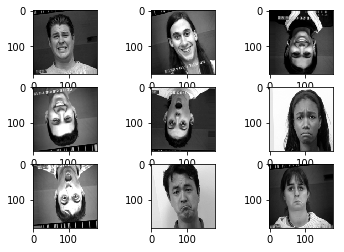

In [15]:
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(180, 180), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [16]:
x_train_batch = datagen.flow(x=x_train, y=y_train, batch_size=batch_size,
                             subset='training')
x_valit_batch = datagen.flow(x=x_train, y=y_train, batch_size=batch_size,
                             subset='validation')

stepsPerEpoche = len(x_train_batch)/batch_size
validationSteps = len(x_valit_batch)/batch_size

## Modelo

### MiniVGG

In [20]:
def build_MiniVGG(width, height, depth, classes):
  # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)# first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3, 3), padding="same",
    input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=2))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=2))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

### Proposto

In [17]:
def proposto1(width, height, depth, classes):
    model = Sequential()
    
    inputShape = (height, width, depth)
    model.add(Conv2D(64, (3, 3), padding="same",
                     input_shape=inputShape,
                     activation="relu",
                     kernel_regularizer=l2(1e-5),
                     bias_regularizer=l2(1e-5)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding="same",
                     activation="relu",
                     kernel_regularizer=l2(1e-5),
                     bias_regularizer=l2(1e-5)))
    model.add(BatchNormalization(axis=2))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding="same",
                    activation="relu",
                    kernel_regularizer=l2(1e-5),
                    bias_regularizer=l2(1e-5)))
    model.add(BatchNormalization(axis=2))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation="relu",
                    kernel_regularizer=l2(1e-5),
                    bias_regularizer=l2(1e-5)))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation="relu",
                    kernel_regularizer=l2(1e-5),
                    bias_regularizer=l2(1e-5)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

### Compilar modelo

In [18]:
opt = SGD(lr=0.01, momentum=0.9, decay=0.001, nesterov=True)
# model = build_MiniVGG(width=180, height=180, depth=1, classes=num_classes)
model = proposto1(width=180, height=180, depth=1, classes=num_classes)

model.compile(loss='categorical_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Treinar o modelo

In [ ]:
checkpointer = ModelCheckpoint(filepath='outputs/checkpointer/model.weights.best.proposto1.hdf5',
                               verbose=1, 
                               save_best_only=True)

hist = model.fit_generator(x_train_batch, epochs=20,
                 validation_data=x_valit_batch, callbacks=[checkpointer], 
                 steps_per_epoch=stepsPerEpoche, validation_steps=validationSteps,
                 verbose=1, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
7/6 [=================================] - 56s 8s/step - loss: 3.9828 - acc: 0.1746 - val_loss: 14.3799 - val_acc: 0.1111

Epoch 00001: val_loss improved from inf to 14.37986, saving model to outputs/checkpointer/model.weights.best.proposto1.hdf5
Epoch 2/20
7/6 [=================================] - 41s 6s/step - loss: 4.6211 - acc: 0.1905 - val_loss: 11.3381 - val_acc: 0.2222

Epoch 00002: val_loss improved from 14.37986 to 11.33813, saving model to outputs/checkpointer/model.weights.best.proposto1.hdf5
Epoch 3/20
7/6 [=================================] - 41s 6s/step - loss: 6.4907 - acc: 0.1746 - val_loss: 12.9692 - val_acc: 0.1667

Epoch 00003: val_loss did not improve from 11.33813
Epoch 4/20
7/6 [=================================] - 42s 6s/step - loss: 8.7210 - acc: 0.1746 - val_loss: 14.8439 - val_acc: 0.0556

Epoch 00004: val_loss did not improve from 11.33813
Epoch 5/20
7/6 [=================================] - 40s 6s/ste

In [1]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), hist.history["loss"], label="train_loss" )
plt.plot(np.arange(0, 20), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), hist.history["acc" ], label="train_acc" )
plt.plot(np.arange(0, 20), hist.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

NameError: name 'plt' is not defined